# Binary Systems in Astrophysics WS 2021/2022

For this tutorial we will learn how to use inference models to extract physical information from gravitational wave's data. We will use data from the LIGO and VIRGO observatories (Avanced LIGO: https://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001; Advanced VIRGO: https://iopscience.iop.org/article/10.1088/1742-6596/610/1/012014) observatories. In particular, we will use data from the first and second gravitational wave catalogs (GWTC-1, https://journals.aps.org/prx/abstract/10.1103/PhysRevX.9.031040 ; GWTC-2, https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.021053).

We will employ the tool PyCBC, developed by members of the two collaborations (https://pycbc.org/, https://arxiv.org/abs/1807.10312). This is the second out of two tutorials, based on the online documentation and the github site of the package (http://pycbc.org/pycbc/latest/html/# , https://github.com/gwastro/PyCBC-Tutorials). Such resulting tutorial is certainly an oversimplification! For a more detailed analysis, check the original material.

As always, you can get this jupyter notebook entering your local binary folder linked to GitLab and pulling the new material:

$ git pull

If you still do not have PyCBC, you can install it with ...

$ pip install pycbc

 ## 9. Data analysis of Gravitational Waves II

As last week, we will use many simplifications and use the code (almost) as a black-box. Be aware that a complete analysis requires significantly more steps and time that in this tutorial. 

Unfortunaly the code will only work if we downgrade the package "emcee". This package is an algorithm for sampling the likelihood space with an ensemble of points (i.e. the "random walkers"). Check out https://emcee.readthedocs.io/en/stable/ for the details.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

First we need to download the date and prepare it. In order to follow the PyCBC tutorial, we will use as an example the NS+NS detection GW 170817.

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
  

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd

Processing H1 data
Processing V1 data
Processing L1 data


We will atempt to create our own models using "pycbc.inference", which basically means that we will sample with a likelihood function using MCMC. In order to do so, we will creat "configuration files" as a support to run it.

We start creating the likelihood model configuration file

In [3]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 25.
"""

In [4]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = single_template
low-frequency-cutoff = 25.



Then we proceed defining the detectors to be used, time, frequency cuts, psd ...

In [5]:
data_config = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 15
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN
""".format(event_tc=Merger("GW170817").time,
           h1file=data_filenames['H1'],
           l1file=data_filenames['L1'],
           v1file=data_filenames['V1'])

In [6]:
!echo '{data_config}' > data.ini
!cat data.ini


[data]
instruments = H1 L1 V1
trigger-time = 1187008882.4
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 15
pad-data = 8
sample-rate = 2048
frame-files = H1:/home/willde/.astropy/cache/download/url/c484b43c2c76aaf6fca1a057f4d6ed52/contents L1:/home/willde/.astropy/cache/download/url/9bb63179cc5cca254380aeb2ee25fd0d/contents V1:/home/willde/.astropy/cache/download/url/51cfa540d575027e191b029fedbda5db/contents
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN



And the important part: we should create a prior configuration file defining those variables that are free parameters, fixed and their priors. In order to simplify the analysis, we fix some of the parameters and leave only distance, inclination and tc.

In [7]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [8]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
distance =
inclination =
delta_tc =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



The MCMC is done using emcee, a python implementation of an algorithm to sample with ensemble of "walkers" the likelihood function. 

In [9]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 400
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [10]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 400
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



Finally we run our MCMC and save our result in a file "inference.hdf"

In [11]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference.hdf \
    --seed 28572013 \
    --nprocesses 8 \
    --force    

2021-12-17 09:47:57,872 Using seed 28572013
2021-12-17 09:47:57,873 Running with CPU support: 1 threads
2021-12-17 09:47:57,873 Reading configuration file
2021-12-17 09:47:57,876 Setting up model
2021-12-17 09:47:57,878 Setting up priors for each parameter
2021-12-17 09:47:57,879 No sampling_params section read from config file
2021-12-17 09:47:57,879 Loading waveform transforms
2021-12-17 09:47:57,883 Determining analysis times to use
2021-12-17 09:47:57,883 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-17 09:47:57,883 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-17 09:47:57,883 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-17 09:47:57,884 Reading Frames
2021-12-17 09:48:05,717 Highpass Filtering
2021-12-17 09:48:05,809 Resampling data
2021-12-17 0

We can easily load it and plot the results

In [12]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr

2021-12-17 09:51:13,548 Reading input file inference.hdf
2021-12-17 09:51:13,549 Loading samples
2021-12-17 09:51:13,562 Loaded 2800 samples
2021-12-17 09:51:13,562 Getting samples for colorbar
2021-12-17 09:51:13,573 Plotting
2021-12-17 09:51:15,488 Done


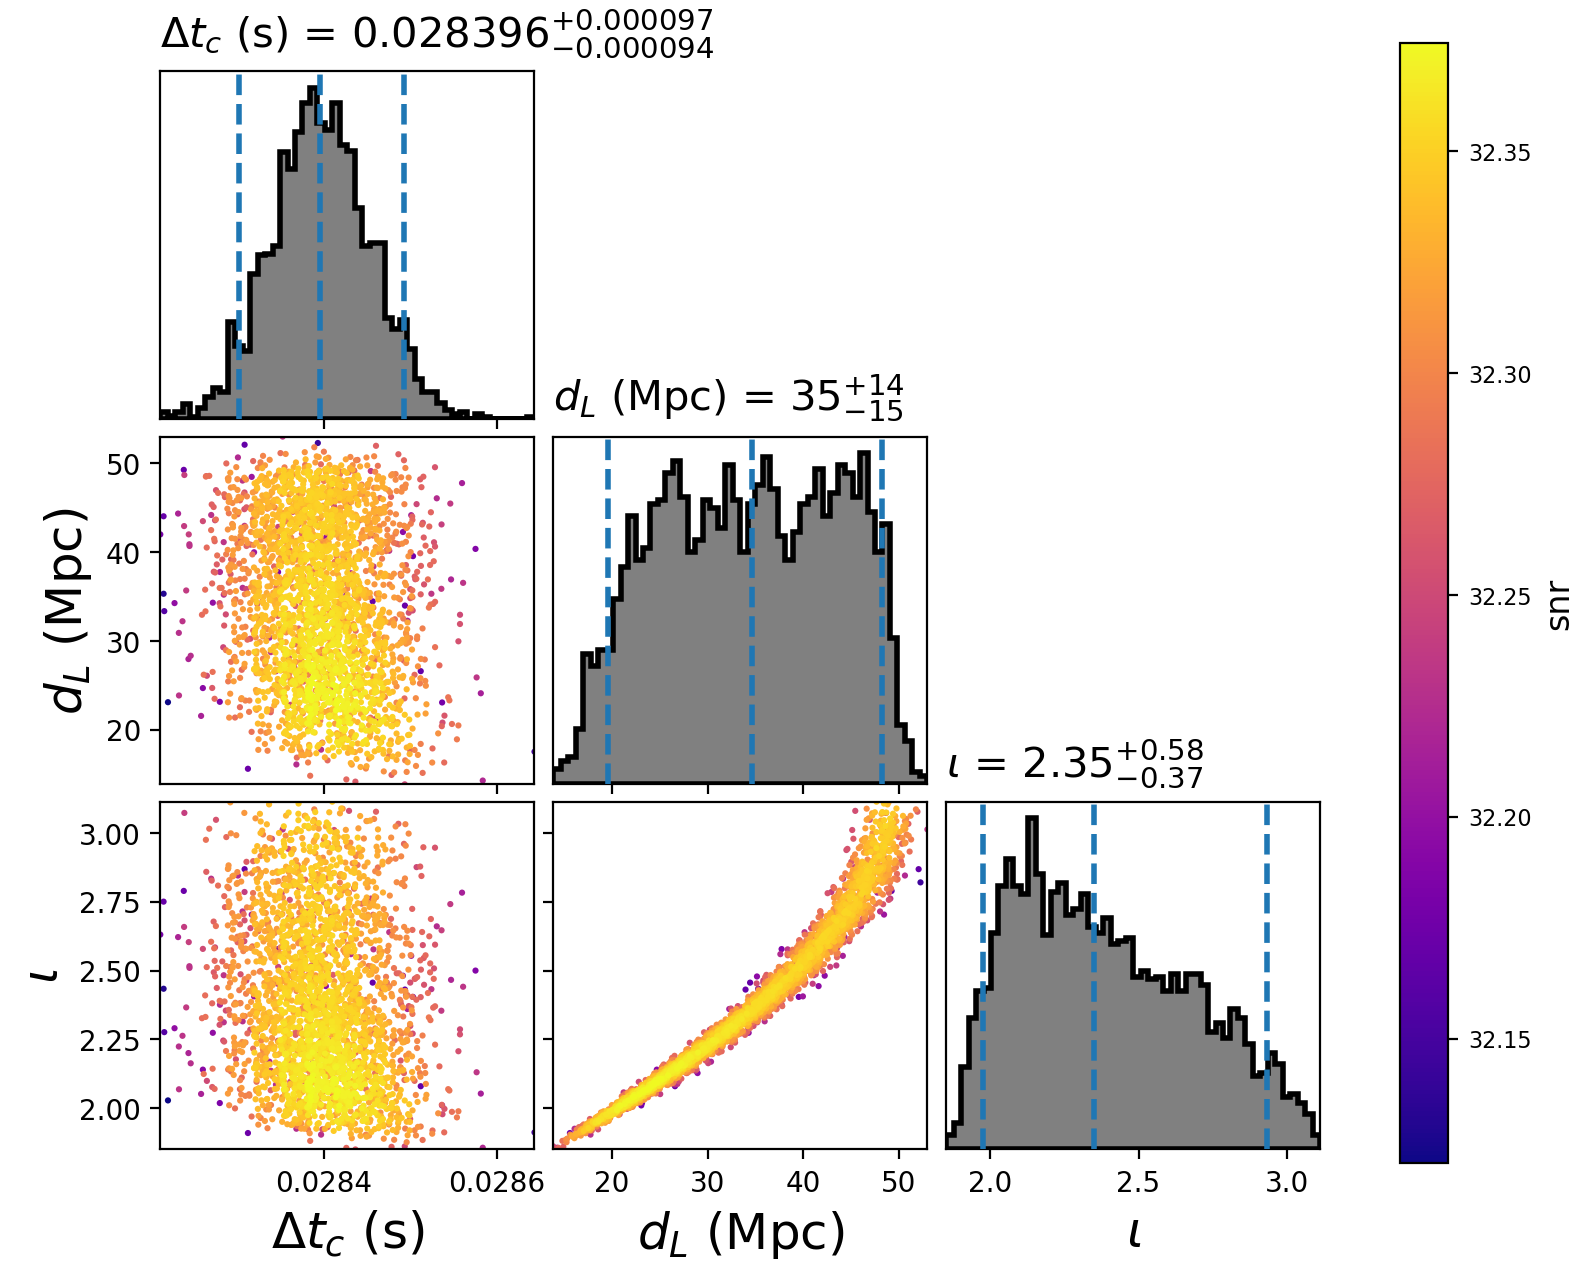

In [13]:
from IPython.display import Image
Image('posterior.png', height=480)

And what if we are only interested in two parameters?

In [14]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior-dist_inc.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters inclination distance

2021-12-17 09:52:54,200 Reading input file inference.hdf
2021-12-17 09:52:54,202 Loading samples
2021-12-17 09:52:54,211 Loaded 2800 samples
2021-12-17 09:52:54,212 Plotting
2021-12-17 09:52:56,494 Done


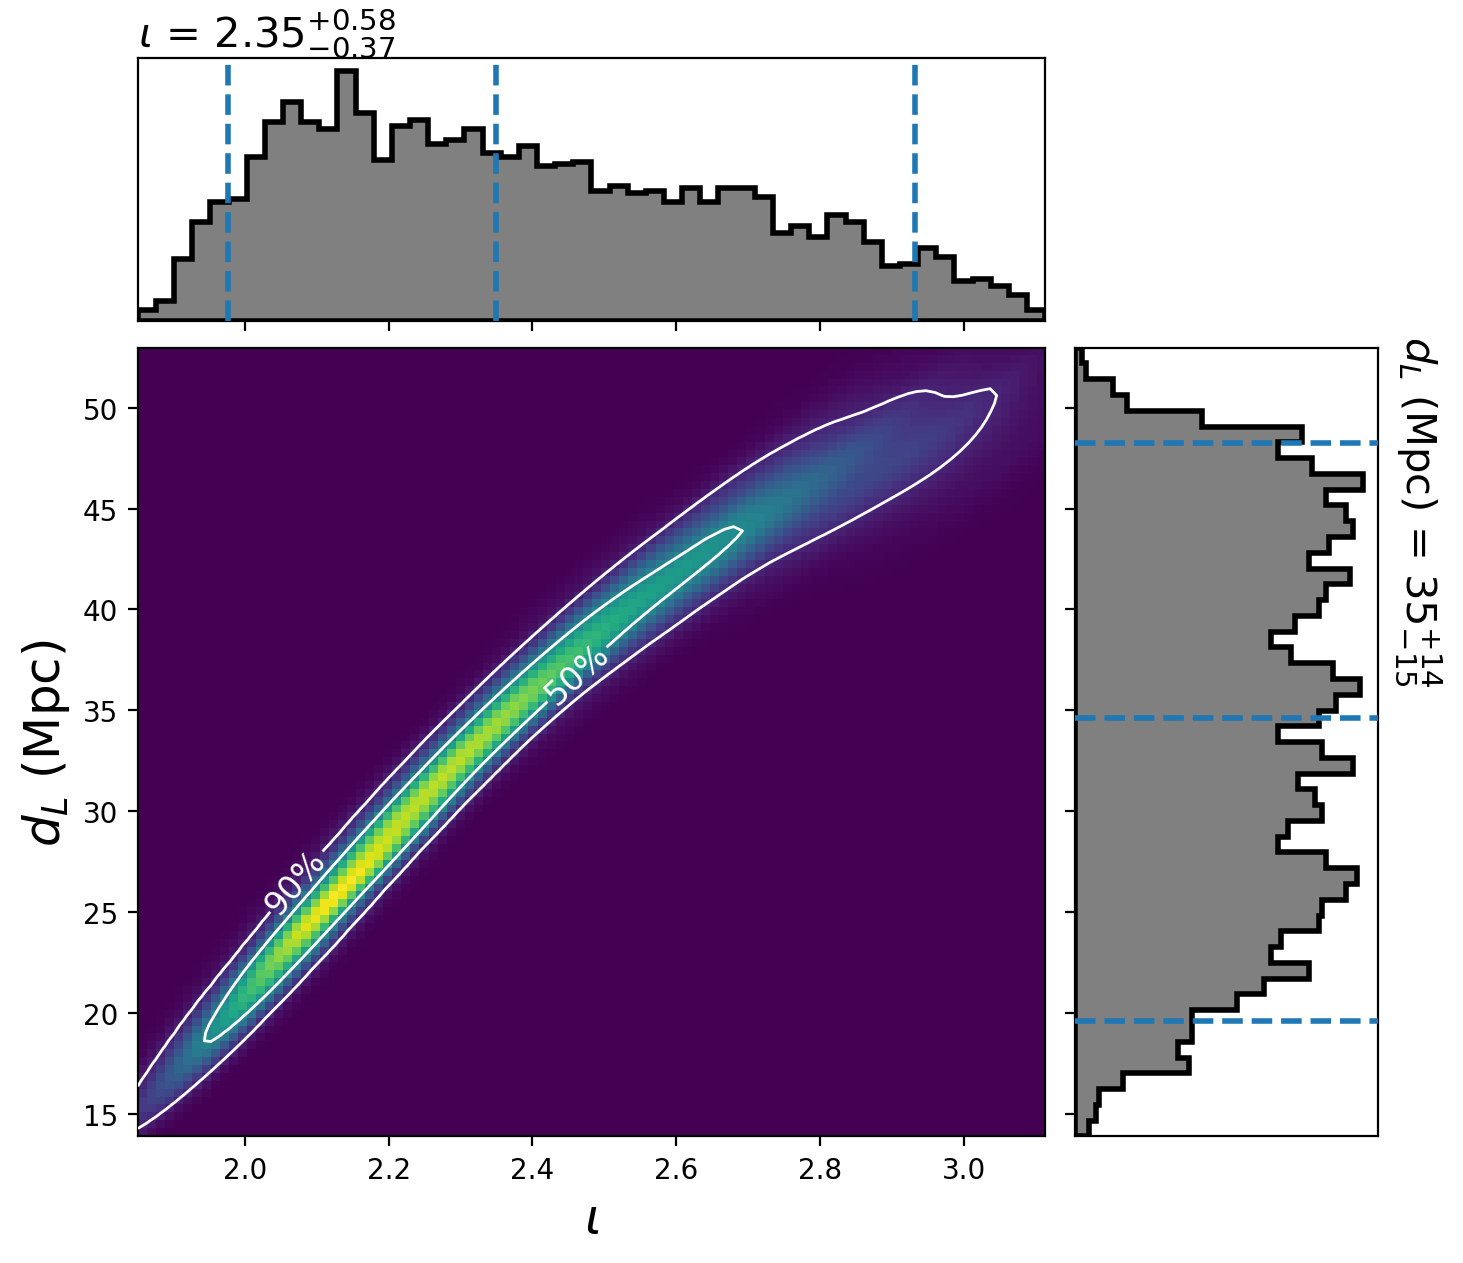

In [15]:
Image('posterior-dist_inc.png', height=480)

Until now we have only explored the distance and inclination space. What would happen if we want to obtain the chirp mass? We will also have as a free parameter the symmetric mass ratio $\eta$:

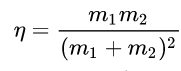

In [16]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}
"""

In [17]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}



In [18]:
prior_config = """
[variable_params]
mchirp =
eta =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 40
inclination = 3.0
delta_tc = 0.028365

[prior-mchirp]
name = uniform
min-mchirp = 1.1876
max-mchirp = 1.2076

[prior-eta]
name = uniform
min-eta = 0.23
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [19]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mchirp =
eta =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 40
inclination = 3.0
delta_tc = 0.028365

[prior-mchirp]
name = uniform
min-mchirp = 1.1876
max-mchirp = 1.2076

[prior-eta]
name = uniform
min-eta = 0.23
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [20]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2021-12-17 09:56:06,064 Using seed 3214897
2021-12-17 09:56:06,064 Running with CPU support: 1 threads
2021-12-17 09:56:06,064 Reading configuration file
2021-12-17 09:56:06,073 Setting up model
2021-12-17 09:56:06,075 Setting up priors for each parameter
2021-12-17 09:56:06,075 No sampling_params section read from config file
2021-12-17 09:56:06,075 Loading waveform transforms
2021-12-17 09:56:06,078 Determining analysis times to use
2021-12-17 09:56:06,078 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-17 09:56:06,078 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-17 09:56:06,078 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-12-17 09:56:06,080 Reading Frames
2021-12-17 09:56:12,971 Highpass Filtering
2021-12-17 09:56:13,074 Resampling data
2021-12-17 09

In [21]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr \
    --parameters mchirp eta

2021-12-17 10:02:07,566 Reading input file inference-masses.hdf
2021-12-17 10:02:07,567 Loading samples
2021-12-17 10:02:07,575 Loaded 3600 samples
2021-12-17 10:02:07,575 Getting samples for colorbar
2021-12-17 10:02:07,580 Plotting
2021-12-17 10:02:08,067 Substituting symbol M from STIXNonUnicode
2021-12-17 10:02:08,143 Substituting symbol M from STIXNonUnicode
2021-12-17 10:02:08,371 Substituting symbol M from STIXNonUnicode
2021-12-17 10:02:08,418 Substituting symbol M from STIXNonUnicode
2021-12-17 10:02:08,823 Done


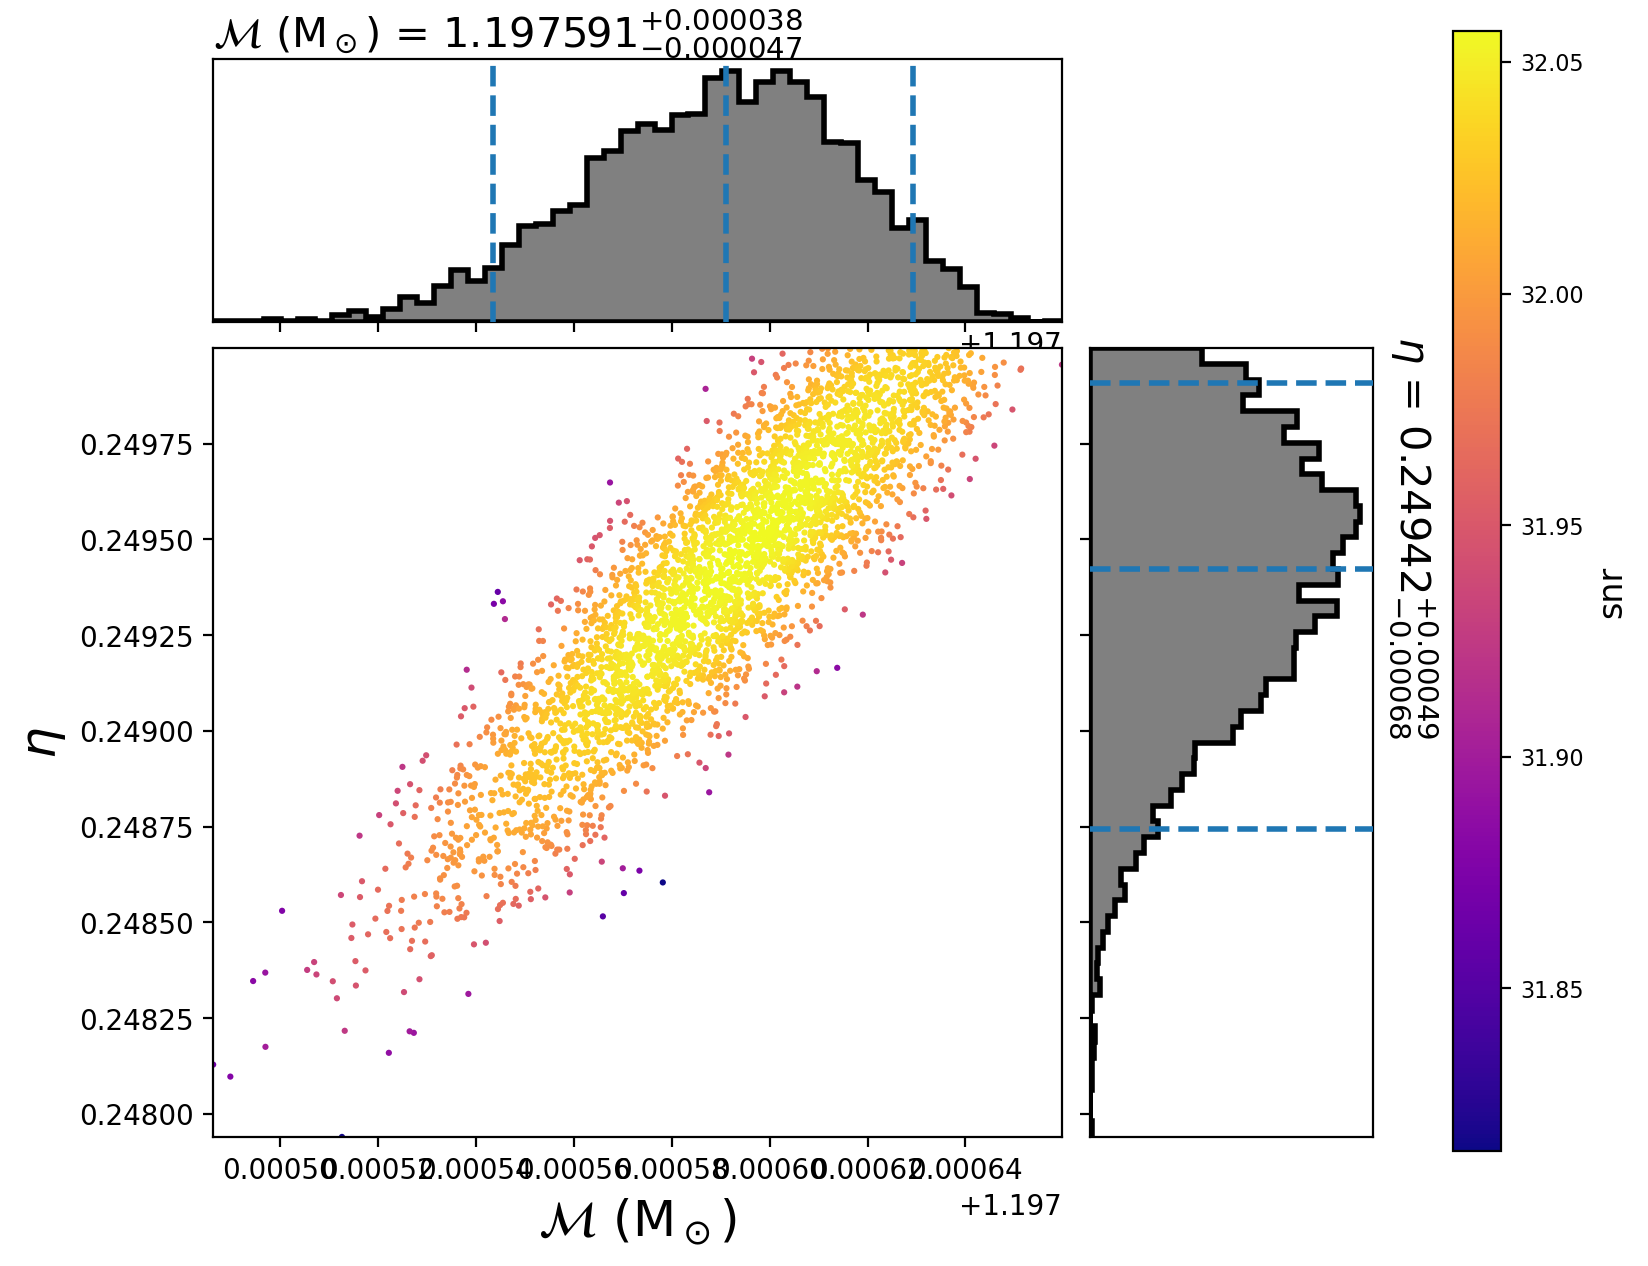

In [22]:
Image('posterior.png', height=480)

### Exercise

Try to extract parameters from the signal from the last tutorial, GW 150914 (it is not trivial!). You will find the data in the data folder, and it can be loaded as

In [ ]:
ifos = ['H1', 
        'L1',
       ]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

data_filenames['H1'] = '../data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.gwf'
data_filenames['L1'] = '../data/L-L1_GWOSC_4KHZ_R1-1126257415-4096.gwf'

Such data is downloaded from https://www.gw-openscience.org/eventapi/html/allevents/ . There you can access all data from the known GW mergers.

You can modify the observatory loop to read the data as

In [ ]:
for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    fname = data_filenames[ifo]

    # Note that the channel will depend on the data
    ts = read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo),
                    start_time=int(m.time - 60),
                    end_time=int(m.time + 60))

In [24]:
m = Merger("GW150914")

# List of observatories we'll analyze
ifos = ['H1', 
        'L1', 
       ]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

data_filenames['H1'] = '../data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.gwf'
data_filenames['L1'] = '../data/L-L1_GWOSC_4KHZ_R1-1126257415-4096.gwf'

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    fname = data_filenames[ifo]

    # Note that the channel will depend on the data
    ts = read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo),
                    start_time=int(m.time - 60),
                    end_time=int(m.time + 60))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-12, m.time + 12) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd

Processing H1 data
Processing L1 data
